# Empirical Economics

## Background information and data

This notebook is dedicated to a light replication of the results of [“Salience of carbon taxes on the gasoline market”](https://poseidon01.ssrn.com/delivery.php?ID=309005119000108065093008082080074106038014065052025018106008068092113112127124073090119100011104103058029066092083082116095082103020047002042073079087081009078112019000012000126000108070117015123125028090005094114003005093099109068118022093067097083112&EXT=pdf), Rivers & Schaufele 2014. The dataset was kindly provided by Pr. Schaufele ; the description of the data can be found in the above mentioned paper.

The notebook should be read as an exploratory analysis of a part of the data and is **not** a full on replication of the study nor is it a robustness check. It can rather be seen as a couple steps in the replication direction and a short coding experience of the impact of carbon taxes.


To give a quick rundown, the dataset originates from a mix of different surveys, found at [statcan](https://www.statcan.gc.ca/eng/start). As mentioned in the original paper, the data was inflation-adjusted on a monthly basis and is province specific. I also added a dummy time variable to create a two-period separation in the data.

In [115]:
### Imports ###

import os

import pandas as pd                   # I/O and data manipulation

import numpy as np                    # Computation

import matplotlib
import matplotlib.pyplot as plt       # Plotting
plt.style.use("ggplot")
%matplotlib inline

plt.rcParams['mathtext.fontset'] = 'stix'   # Pretty plotting
plt.rcParams['font.family'] = 'STIXGeneral' 

from pandas.plotting import register_matplotlib_converters  # Matplotlib utils
register_matplotlib_converters()

import seaborn as sns
sns.set(rc = {'figure.dpi' : 180, 'mathtext.fontset' : 'stix', 'font.family' : 'STIXGeneral'})

import statsmodels.api as sm        # Statistics and Regressions

for i in (pd, np, matplotlib, sm, sns):  # Versions' references
    print(i.__version__)

0.25.1
1.17.1
3.1.1
0.10.1
0.9.0


In [2]:
def clean_monthly():
    
    """The function cleans the data to be easily input for the 
       statsmodels API and adds a time dummy.
       
    Parameters
    ----------
    None
    
    Returns
    -------
    df : Cleaned pandas dataframe
    """
    data_path = os.getcwd() + '\\data\\'
    df = pd.read_csv(data_path+'Data_Gas_Month_Dom.csv')
    df['Ref_Date'] = pd.to_datetime(df['Ref_Date'],format="%d/%m/%Y")
    df = df.set_index(df["Ref_Date"]).drop(
        ["Unnamed: 0","month"],axis=1)
    df['time_dummy'] = np.where(df.index > "2008-01-07", 1,0)
    return df

In [138]:
df = clean_monthly().dropna()
df.head()

Ref_Date  year      GEO  AB  BC  MN  NB  NFLD  NS  ON  ...  \
Ref_Date                                                            ...   
1990-01-01 1990-01-01  1990  Alberta   1   0   0   0     0   0   0  ...   
1990-02-01 1990-02-01  1990  Alberta   1   0   0   0     0   0   0  ...   
1990-03-01 1990-03-01  1990  Alberta   1   0   0   0     0   0   0  ...   
1990-04-01 1990-04-01  1990  Alberta   1   0   0   0     0   0   0  ...   
1990-05-01 1990-05-01  1990  Alberta   1   0   0   0     0   0   0  ...   

            Excise_Real  Tax_ad_val     PIT    CIT      Inc_Nom     Inc_Real  \
Ref_Date                                                                       
1990-01-01     6.839945    0.104384  2941.0  855.0  1406.939405  1924.677709   
1990-02-01     6.811989    0.102249  2941.0  855.0  1406.939405  1916.811179   
1990-03-01     6.793478    0.100604  2941.0  855.0  1406.939405  1911.602453   
1990-04-01     6.747638    0.096339  2941.0  855.0  1406.939405  1898.703651   
1990-05-01     9.421265    0.134875  2941.0  855.0  1406.939405  1893.592739   

            CarbTax  Excise_RealBC  gasPriceRealBC  time_dummy  
Ref_Date                                                        
1990-01-01      0.0            0.0             0.0           0  
1990-02-01      0.0            0.0             0.0           0  
1990-03-01      0.0            0.0             0.0           0  
1990-04-01      0.0            0.0             0.0           0  
1990-05-01      0.0            0.0             0.0           0  

[5 rows x 34 columns]

We know have a cleaned and proper dataframe, not much work was required since the data was already properly formatted and the idiosyncracies had been taken care of. The next few lines of code will be dedicated to create plots and visualizations of the data, for us to understand what we are actually dealing with. Next, I will create some regressions akin to the original paper, in order the replicate the results and add some commentary.

## Plots and descriptive statistics

Let us get a quick view of descriptive statistics.

In [4]:
relevant_columns = [col for col in df.columns if ('gas' in col) | ('BC' in col)]
other_cols = [col for col in df.columns if col not in relevant_columns]
df[relevant_columns].describe()

BC  gasolineConsumption  gasPriceNom    gasPerCap  \
count  2640.000000         2.580000e+03  2580.000000  2580.000000   
mean      0.100000         3.251233e+05    76.403488   144.029545   
std       0.300057         3.613566e+05    23.505785    34.247445   
min       0.000000         1.141200e+04    39.500000    83.632874   
25%       0.000000         8.367800e+04    56.900000   119.400423   
50%       0.000000         1.324105e+05    69.100000   135.334196   
75%       0.000000         4.416665e+05    94.700000   161.649465   
max       1.000000         1.582977e+06   146.800000   303.033552   

       gasPriceReal  Excise_RealBC  gasPriceRealBC  
count   2580.000000    2640.000000     2640.000000  
mean      75.959117       1.229384        7.773299  
std       14.681820       3.699934       24.004655  
min       48.017149       0.000000        0.000000  
25%       64.673444       0.000000        0.000000  
50%       72.415801       0.000000        0.000000  
75%       85.595974       0.000000        0.000000  
max      128.371278      14.215686      128.371278

In [5]:
df[other_cols].describe()

year           AB           MN           NB         NFLD  \
count  2640.000000  2640.000000  2640.000000  2640.000000  2640.000000   
mean   2000.500000     0.100000     0.100000     0.100000     0.600000   
std       6.345491     0.300057     0.300057     0.300057     0.489991   
min    1990.000000     0.000000     0.000000     0.000000     0.000000   
25%    1995.000000     0.000000     0.000000     0.000000     0.000000   
50%    2000.500000     0.000000     0.000000     0.000000     1.000000   
75%    2006.000000     0.000000     0.000000     0.000000     1.000000   
max    2011.000000     1.000000     1.000000     1.000000     1.000000   

                NS           ON          PEI           QC           SK  ...  \
count  2640.000000  2640.000000  2640.000000  2640.000000  2640.000000  ...   
mean      0.100000     0.100000     0.100000     0.100000     0.100000  ...   
std       0.300057     0.300057     0.300057     0.300057     0.300057  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
max       1.000000     1.000000     1.000000     1.000000     1.000000  ...   

       cTaxRealCents   ProvExcise  Excise_Real   Tax_ad_val           PIT  \
count    2580.000000  2580.000000  2580.000000  2580.000000   2340.000000   
mean        0.068477    13.206550    13.476641     0.184168   5312.440171   
std         0.462054     2.535996     2.543408     0.049722   6960.915299   
min         0.000000     5.000000     6.747638     0.068079    104.000000   
25%         0.000000    11.000000    11.899698     0.146898    923.000000   
50%         0.000000    14.000000    13.513514     0.184746   1629.000000   
75%         0.000000    15.000000    15.094340     0.214286   6036.000000   
max         5.150215    22.300000    19.910314     0.318182  28674.000000   

               CIT      Inc_Nom     Inc_Real      CarbTax   time_dummy  
count  2340.000000  2460.000000  2460.000000  2640.000000  2640.000000  
mean   1245.944444  1705.471900  1728.695178     0.054775     0.178030  
std    1857.791195   410.508538   242.390988     0.450089     0.382611  
min      12.000000  1047.425559  1283.398792     0.000000     0.000000  
25%     138.000000  1379.508024  1544.381736     0.000000     0.000000  
50%     310.000000  1600.216682  1689.641659     0.000000     0.000000  
75%    1673.000000  1981.718947  1873.683655     0.000000     0.000000  
max    8388.000000  3157.075332  2618.613797     5.150215     1.000000  

[8 rows x 25 columns]

I think those statistics do not make a good job at representing what we are after and we will rather focus on plotting. They're still helpful for us to note if something is wrong in the scope of the variables, that is if nonsensical values are present.

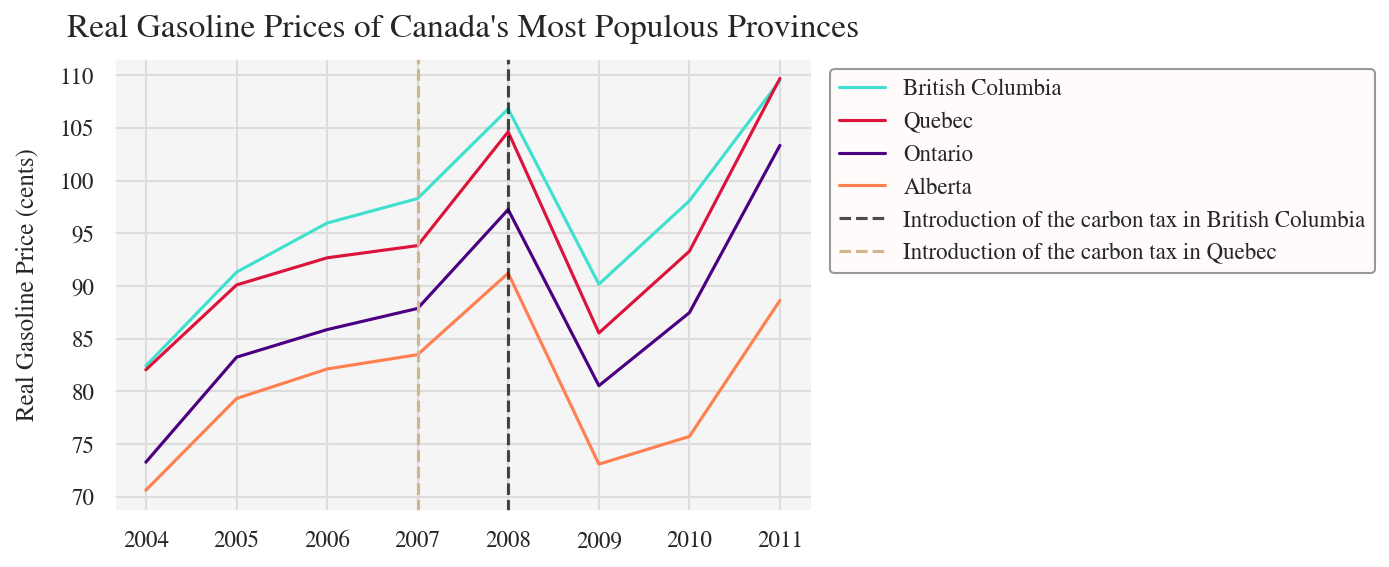

In [141]:
def plot_gas():
    
    """Creates a plot of the annual gas prices for different Canadian provinces
       with added coloring and lines to hopefully create a compelling picture of the research question.
       
    Parameters
    ----------
    None
    
    Returns
    -------
    A matplotlib plot object
    """
    fig, ax = plt.subplots(dpi=150)
    data_path = os.getcwd() + '\\data\\'
    annual = pd.read_csv(data_path+'annual_data_Dom.csv')
    annual["YEAR"] = pd.to_datetime(annual['YEAR'],format="%Y")
    annual = annual.set_index(annual['YEAR'])
    plt.plot(annual[annual['GEO'] == "BC"]['gas_price']["2004":],label="British Columbia",c="turquoise")
    plt.plot(annual[annual['GEO'] == "Quebec"]['gas_price']['2004':],label="Quebec",c="crimson")
    plt.plot(annual[annual['GEO'] == "Ontario"]['gas_price']['2004':],label="Ontario",c="indigo")
    plt.plot(annual[annual['GEO'] == "Alberta"]['gas_price']['2004':],label="Alberta",c="coral")
    

    plt.axvline(x="2008",c="black",alpha=0.7,linestyle="--",label="Introduction of the carbon tax in British Columbia")
    plt.axvline(x="2007",c="tan",alpha=1.,linestyle="--",label="Introduction of the carbon tax in Quebec")
    plt.title("Real Gasoline Prices of Canada's Most Populous Provinces",size=16,pad=10)
    plt.ylabel("Real Gasoline Price (cents)",size=12,labelpad=10)
    ax.set_facecolor('whitesmoke')
    plt.grid(c='gainsboro')
    plt.legend(edgecolor='grey',bbox_to_anchor=(1.01,1),facecolor="snow");
    #fig.savefig("Gasoline Price.png",dpi=300,format="png",frameon=True,bbox_inches="tight")
    
plot_gas()

The plot is interesting because we notice from the outset that the trend in real gas prices are quite similar for the most populous provinces. The trends are not perfectly parallel but eyeballing the data tells us we're on the right track. Still, the parallel trend assumption is decisive in a difference-in-difference setting thus we can't take it lightly. The original paper makes a better case than I do in this short notebook and I advise you read it.

Alright, moving on to the next plot, we will look at gas consumption.

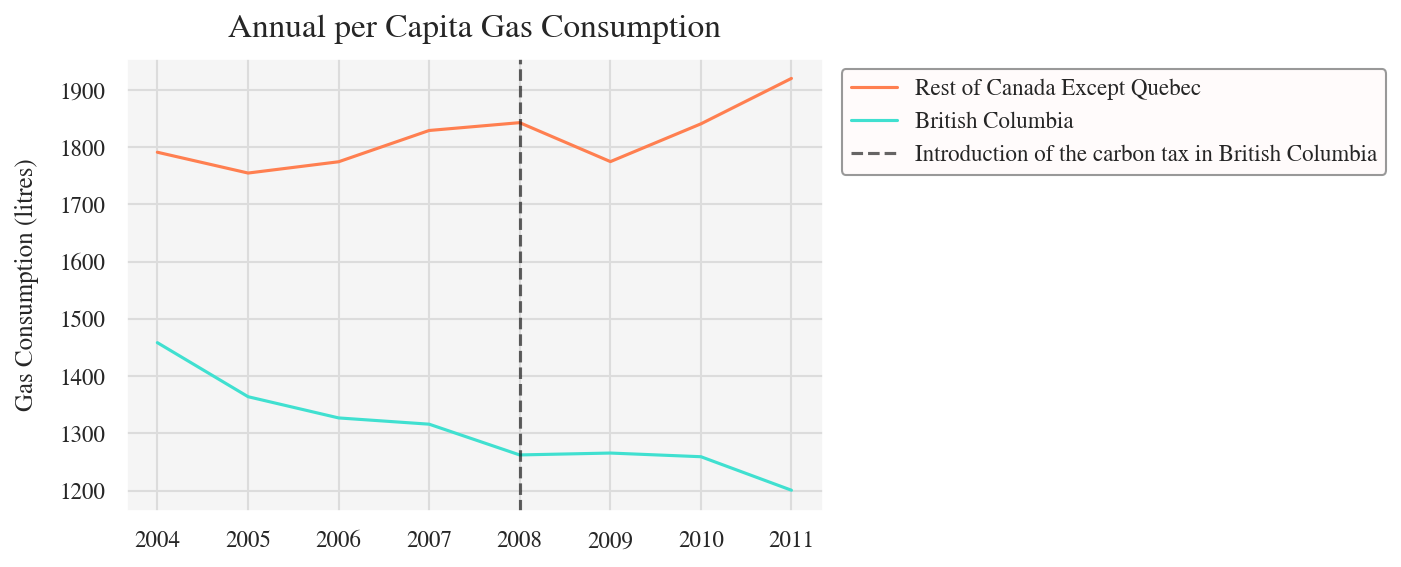

In [142]:
def plot_conso():
    
    """Creates a plot of trends to compare BC's consumption to other provinces,
       except Quebec, as some form of carbon taxing existed starting in 2007.
       
    Parameters
    ----------
    None
    
    Returns
    -------
    A matplotlib plot object
    """
    
    fig, ax = plt.subplots(dpi=150)
    data_path = os.getcwd() + '\\data\\'
    annual = pd.read_csv(data_path+'annual_data_Dom.csv')
    annual["YEAR"] = pd.to_datetime(annual['YEAR'],format="%Y")
    annual = annual.set_index(annual['YEAR'])
    
    plt.plot(annual['perCapGas'][(annual['GEO'] !='British Columbia')
                              & (annual['GEO'] != 'Quebec')].groupby('YEAR').mean()["2004":],
             label="Rest of Canada Except Quebec",c="coral")
    plt.plot(annual['perCapGas'][annual['GEO']=='BC']["2004":],label="British Columbia",c="turquoise")
    plt.axvline(x="2008",c="black",alpha=0.6,linestyle="--",label="Introduction of the carbon tax in British Columbia")
    plt.title("Annual per Capita Gas Consumption",size=16,pad=10)
    plt.ylabel("Gas Consumption (litres)",size=12,labelpad=10)
    plt.grid(c="gainsboro")
    ax.set_facecolor('whitesmoke')
    plt.legend(edgecolor='grey',bbox_to_anchor=(1.01,1),facecolor="snow");
    #fig.savefig("Per Capita Gas Consumption.png",dpi=300,format="png",frameon=True,bbox_inches="tight")


plot_conso()

The above plot is easy to read as it shows that the per capita gas consumption was already on the decline in BC and grew in the other provinces. Note that the other provinces were grouped together and some increasing trends (such as in Alberta) are probably dominating the graph.

The difference in trends is clear and it becomes less clear if the comparison between BC and other provinces makes sense, consumption-wise. Maybe we can get a better look into this issue.

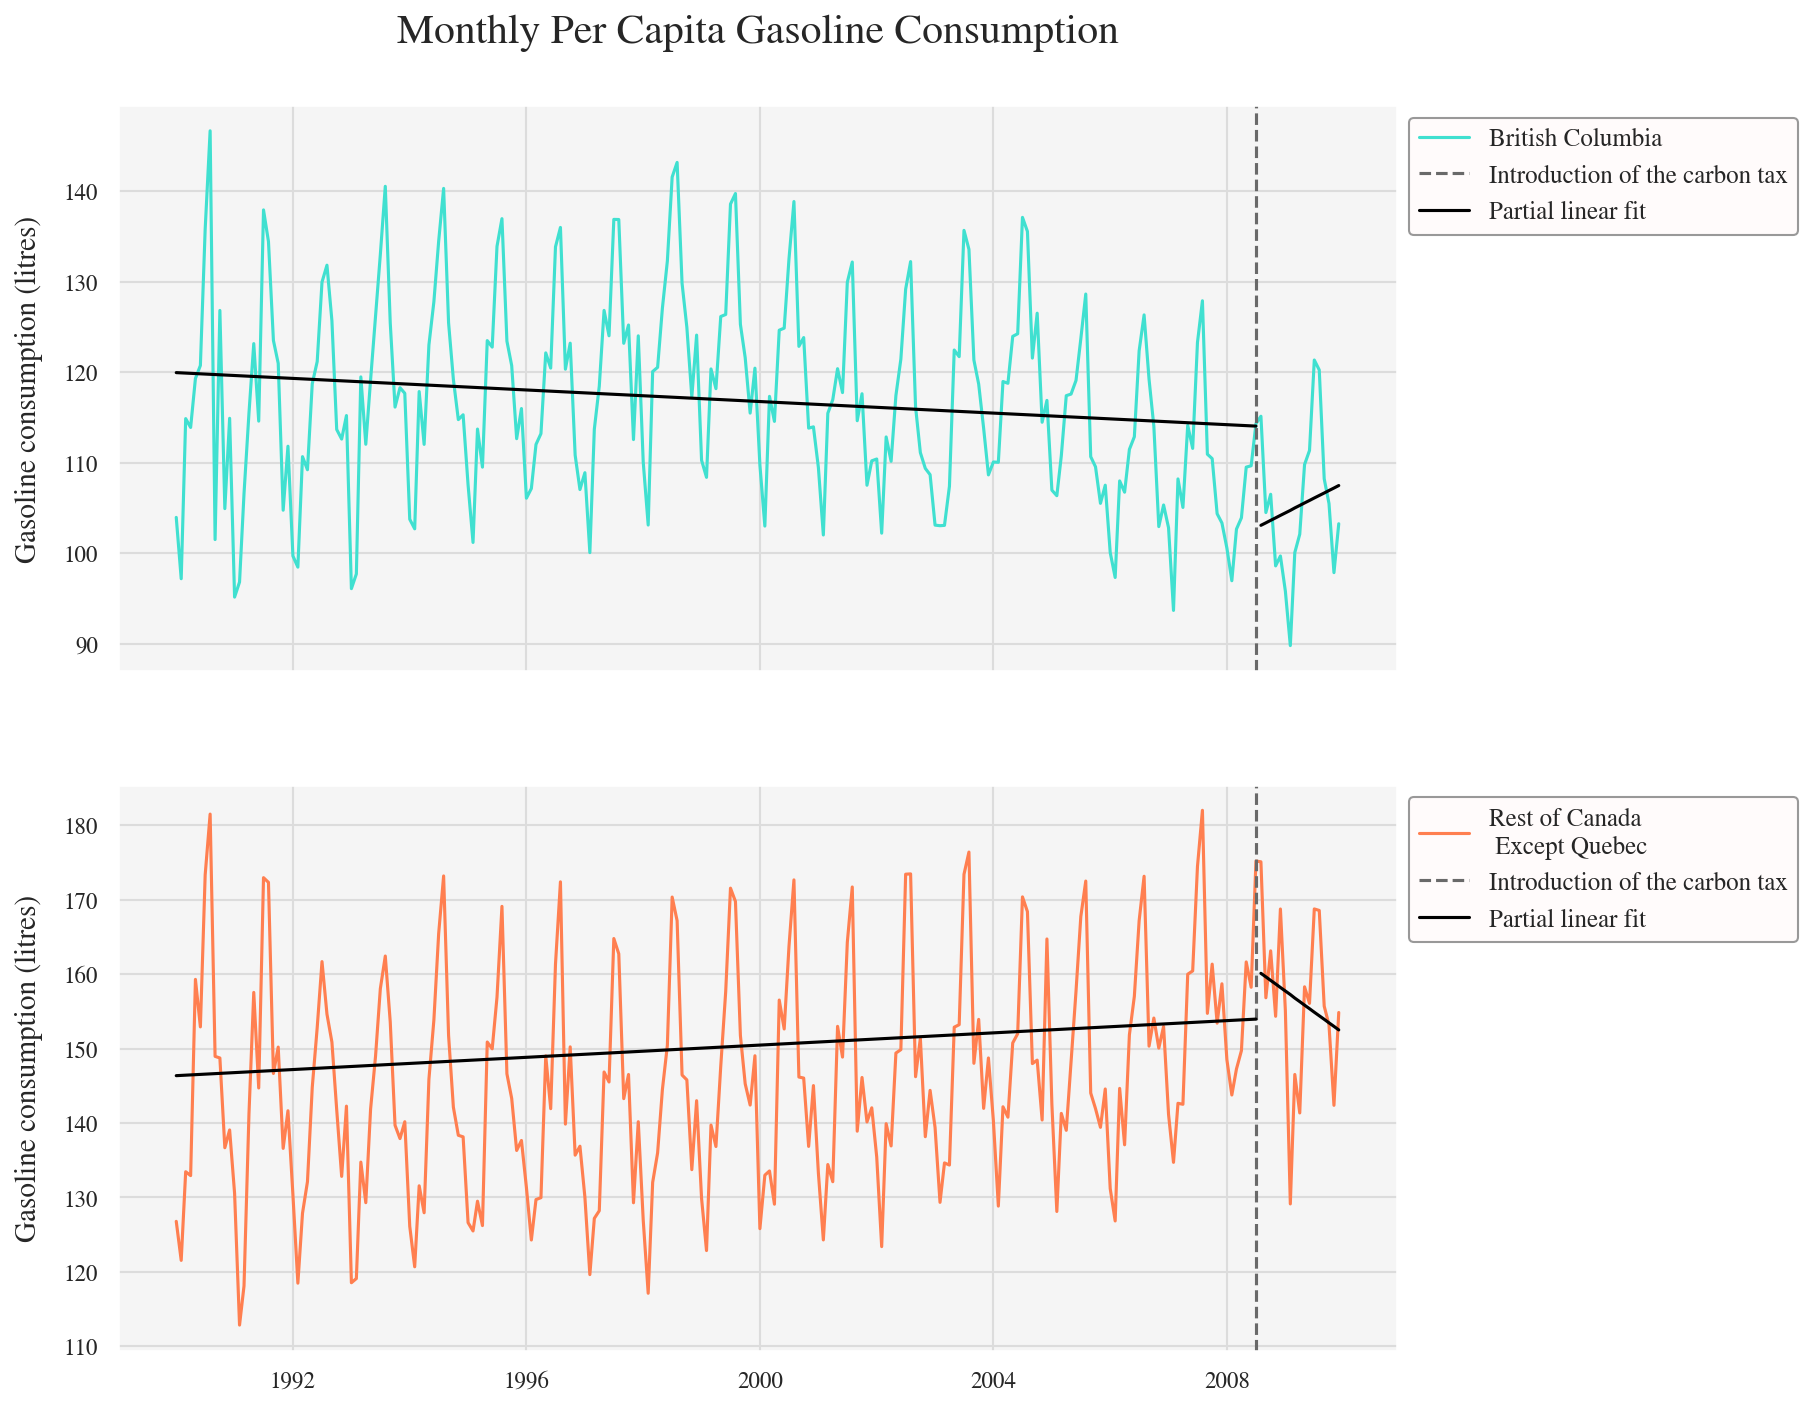

In [143]:
def reg_plot():
    
    """ Creates of plot of monthly consumption and applies partial linear fits to explore the trends
    
      useful ref : https://stackoverflow.com/questions/37337836/linear-regression-with-pandas-time-series
      
    Parameters
    ----------
    None
    
    Returns
    -------
    A matplotlib plot object
    """
    month = df.copy()
    len_series_before = len(month['gasPerCap'][month["GEO"] == "British Columbia"][:'2008-07'])
    len_series_after = len(month['gasPerCap'][month["GEO"] == "British Columbia"]['2008-08':])
    
    time1 = np.arange(len_series_before)
    time2 = np.arange(len_series_after)
    
    fit1 = np.polyfit(time1,month['gasPerCap'][month["GEO"] == "British Columbia"][:'2008-07'],deg=1)
    fit_fn1 = np.poly1d(fit1)
    
    fit2 = np.polyfit(time2,month['gasPerCap'][month["GEO"] == "British Columbia"]['2008-08':],deg=1)
    fit_fn2 = np.poly1d(fit2)
    
    fit3 = np.polyfit(time1,month['gasPerCap'][(month['GEO'] !='British Columbia')
                                  & (month['GEO'] != 'Quebec')].groupby('Ref_Date').mean()[:"2008-07"],deg=1)
    fit_fn3 = np.poly1d(fit3)
    
    fit4 = np.polyfit(time2,month['gasPerCap'][(month['GEO'] !='British Columbia')
                                  & (month['GEO'] != 'Quebec')].groupby('Ref_Date').mean()["2008-08":],deg=1)
    fit_fn4 = np.poly1d(fit4)
    
    
    fig, ax = plt.subplots(2,1,sharex=True,figsize=(11,11),dpi=150)

    ax[0].set_title("Monthly Per Capita Gasoline Consumption",fontsize=20,pad=30)

    ax[0].grid(c="gainsboro")
    ax[0].set_facecolor('whitesmoke')
    ax[0].plot(month['gasPerCap'][month["GEO"] == "British Columbia"][:'2012'],c='turquoise',
               label='British Columbia')
    ax[0].axvline(x='2008-07',c='dimgrey',linestyle="--")
    ax[0].set_ylabel("Gasoline consumption (litres)",labelpad=10,fontsize=14)
    
    ax[0].plot(month['gasPerCap'][month["GEO"] == "British Columbia"][:'2008-07'].index,
               fit_fn1(time1),c='black')
    
    ax[0].plot(month['gasPerCap'][month["GEO"] == "British Columbia"]["2008-08":].index,
               fit_fn2(time2),c='black')
    
    ax[0].legend(('British Columbia','Introduction of the carbon tax',
                 'Partial linear fit'),bbox_to_anchor=(1,1),fontsize=12,edgecolor="grey",facecolor="snow")

    ax[1].plot(month['gasPerCap'][(month['GEO'] !='British Columbia')
                                  & (month['GEO'] != 'Quebec') & (month["GEO"] != "Alberta")].groupby('Ref_Date').mean()[:"2012"],
                 label="Rest of Canada Except Quebec",c="coral")
    ax[1].grid(c="gainsboro")
    ax[1].set_facecolor('whitesmoke')
    ax[1].axvline(x='2008-07',c='dimgrey',linestyle="--")
    ax[1].set_ylabel("Gasoline consumption (litres)",labelpad=10,fontsize=14)
    
    ax[1].plot(month['gasPerCap'][(month['GEO'] !='British Columbia')
                                & (month['GEO'] != 'Quebec') & (month["GEO"] != "Alberta")].groupby('Ref_Date').mean()[:"2008-07"].index,
               fit_fn3(time1),c='black')
    
    ax[1].plot(month['gasPerCap'][(month['GEO'] !='British Columbia')
                                & (month['GEO'] != 'Quebec') & (month["GEO"] != "Alberta")].groupby('Ref_Date').mean()["2008-08":].index,
               fit_fn4(time2),c='black')
    
    ax[1].legend(('Rest of Canada\n Except Quebec','Introduction of the carbon tax',
                  "Partial linear fit"),bbox_to_anchor=(1,1),
                 fontsize=12,edgecolor="grey",facecolor="snow")
    
    #fig.savefig("Linear fits gasoline cons.png",dpi=300,format="png",frameon=True,bbox_inches="tight")
    
reg_plot()

As we can observe a more detailed picture of the gas consumption, we see that there a decrease and increase in gasoline consumption, in British Columbia and the other provinces, respectively. It also looks like that trends are not similar and that we will probably overstate our estimate, let's not forget it !

## Regression estimates and effects

The strategy we will follow is called difference-in-difference (DiD), for a more thorough explanation, see Angrist and Pischke 2009. We will attempt to estimate the effect of carbon taxing on gas consumption, using Ordinary Least Squares (OLS) in a DiD setup. In short, we try to estimate the average treatment effect for the treated (ATT). Which can be written for two groups and two periods as :

$$estimate_{ATT} \equiv E\{Y_{i,t+1}(1) - Y_{i, t+1}(0) | G_i = 1\} = \mu_1 - \mu_0$$

Where $t$ and $t+1$ are the two periods and $G = 0$ refers to the untreated group while $G = 1$ refers to the treated one.

Note that this setup is different than in the original paper as Rivers & Schaufele compare multiple periods. For the sake of this notebook, we will use only two periods : before and after the introduction of the tax. It's also my preferred design because it tackles the autocorrelation of errors issue, as outlined in "[How Much Should We Trust Differences-In-Differences Estimates?](https://www.nber.org/papers/w8841.pdf)" (Bertrand et al. 2004).

The following regression will try to tackle to above mentioned problem, by clustering standard errors at the state level, as explained in [The Causal Mixtape](http://scunning.com/cunningham_mixtape.pdf), Cunningham 2017.

Right before the actual regression, I'd like to plot the variables we'll be working with, to get a quick feel of their distribution. Let's plot them with ``seaborn``.

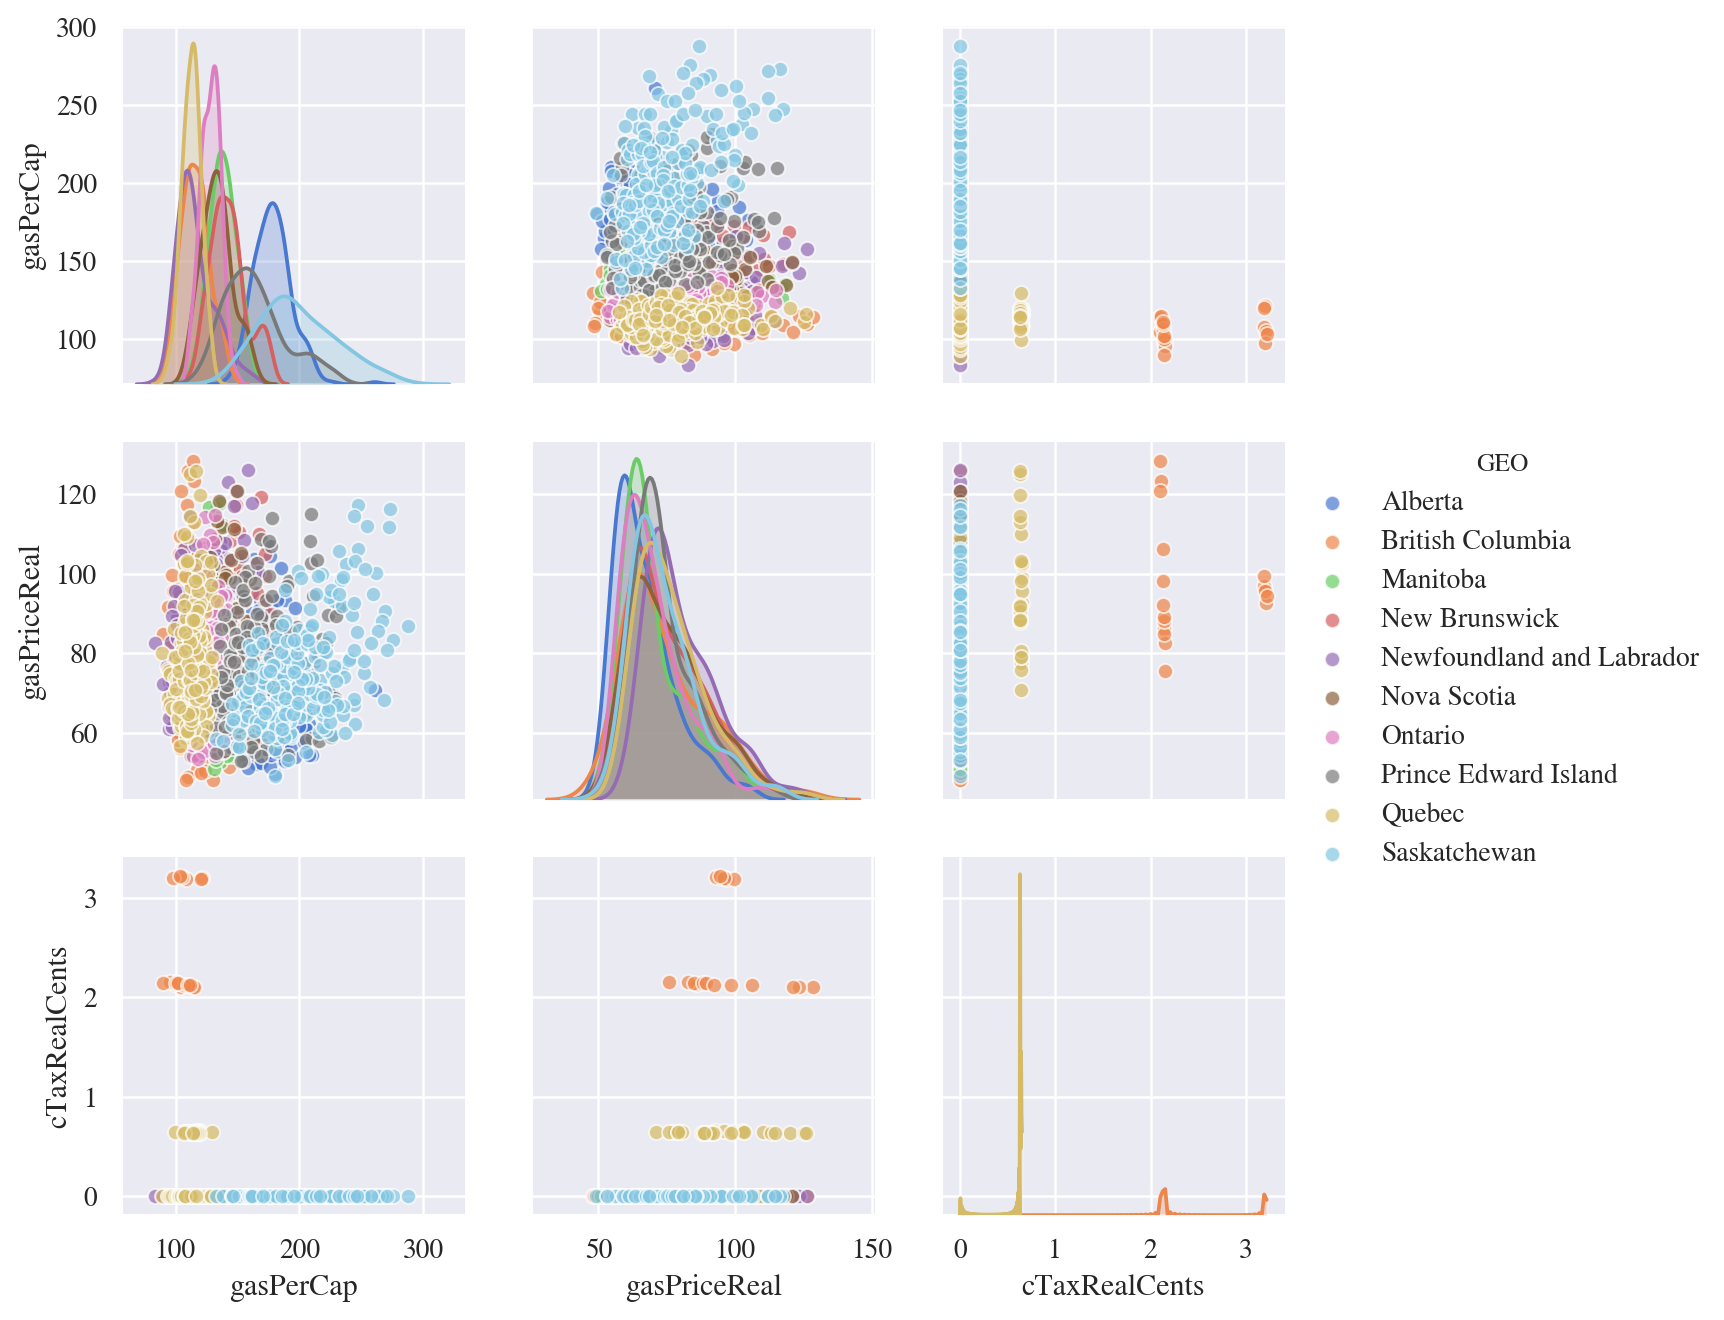

In [144]:
reg_cols = ['gasPerCap', 'gasPriceReal','GEO','cTaxRealCents']
pairs = sns.pairplot(df[reg_cols], hue = 'GEO', palette = 'muted', plot_kws = {'alpha': 0.7})

We can observe different taxing regimes and consumption across Canadian provinces but that visualization is a bit troublesome as the overlapping does not allow for a more in-depth look at the distributions. Let us now do the actual regression.

In [146]:
reg = sm.OLS.from_formula('np.log(gasPerCap) ~ gasPriceReal*GEO - gasPriceReal + \
                                               cTaxRealCents:BC+cTaxRealCents:QC + time_dummy',
                                               data=df).fit()
reg.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Ordinary least squares
============================================================================================
Model:                      OLS                       Adj. R-squared:             0.779     
Dependent Variable:         np.log(gasPerCap)         AIC:                        -4126.9992
Date:                       2019-09-23 15:08          BIC:                        -3994.5674
No. Observations:           2340                      Log-Likelihood:             2086.5    
Df Model:                   22                        F-statistic:                376.6     
Df Residuals:               2317                      Prob (F-statistic):         0.00      
R-squared:                  0.781                     Scale:                      0.0099386 
--------------------------------------------------------------------------------------------
                                             Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------------------------
Intercept                                    5.2458   0.0387 135.4884 0.0000  5.1699  5.3218
GEO[T.British Columbia]                     -0.3997   0.0506  -7.9010 0.0000 -0.4988 -0.3005
GEO[T.Manitoba]                             -0.2974   0.0519  -5.7295 0.0000 -0.3992 -0.1956
GEO[T.New Brunswick]                        -0.4105   0.0549  -7.4752 0.0000 -0.5182 -0.3028
GEO[T.Newfoundland and Labrador]            -0.9066   0.0554 -16.3512 0.0000 -1.0154 -0.7979
GEO[T.Nova Scotia]                          -0.3916   0.0535  -7.3175 0.0000 -0.4965 -0.2867
GEO[T.Ontario]                              -0.4370   0.0541  -8.0697 0.0000 -0.5431 -0.3308
GEO[T.Prince Edward Island]                 -0.3504   0.0554  -6.3199 0.0000 -0.4592 -0.2417
GEO[T.Quebec]                               -0.6152   0.0582 -10.5629 0.0000 -0.7294 -0.5009
GEO[T.Saskatchewan]                         -0.4276   0.0542  -7.8891 0.0000 -0.5339 -0.3213
gasPriceReal:GEO[Alberta]                   -0.0009   0.0006  -1.6399 0.1012 -0.0021  0.0002
gasPriceReal:GEO[British Columbia]          -0.0012   0.0004  -2.7516 0.0060 -0.0021 -0.0003
gasPriceReal:GEO[Manitoba]                  -0.0003   0.0005  -0.6472 0.5175 -0.0013  0.0006
gasPriceReal:GEO[New Brunswick]              0.0016   0.0005   3.1078 0.0019  0.0006  0.0026
gasPriceReal:GEO[Newfoundland and Labrador]  0.0051   0.0005  10.1734 0.0000  0.0041  0.0060
gasPriceReal:GEO[Nova Scotia]                0.0005   0.0005   0.9748 0.3298 -0.0005  0.0014
gasPriceReal:GEO[Ontario]                    0.0006   0.0005   1.1498 0.2503 -0.0004  0.0017
gasPriceReal:GEO[Prince Edward Island]       0.0026   0.0005   4.8633 0.0000  0.0016  0.0037
gasPriceReal:GEO[Quebec]                     0.0012   0.0006   2.1341 0.0329  0.0001  0.0024
gasPriceReal:GEO[Saskatchewan]               0.0063   0.0005  12.1497 0.0000  0.0053  0.0073
cTaxRealCents:BC                            -0.0247   0.0108  -2.2844 0.0224 -0.0459 -0.0035
cTaxRealCents:QC                            -0.0188   0.0389  -0.4843 0.6282 -0.0952  0.0575
time_dummy                                  -0.0013   0.0084  -0.1583 0.8742 -0.0177  0.0151
--------------------------------------------------------------------------------------------
Omnibus:                       50.883                Durbin-Watson:                   0.819 
Prob(Omnibus):                 0.000                 Jarque-Bera (JB):                68.875
Skew:                          0.255                 Prob(JB):                        0.000 
Kurtosis:                      3.668                 Condition No.:                   1607  
============================================================================================
* The condition number is large (2e+03). This might indicate             strong
multicollinearity or other numerical problems.
"""

Looking at the estimate for the carbon tax, we find that a one cent increase in carbon taxing in British Columbia leads to an approximate decrease of 2.4% in per capita consumption. Which is a similar finding to the original where the following statement can be found in the conclusion : " A five cent increase in the carbon tax, all else constant, causes gasoline demand to decline by 12.5% whereas an identical five cent increase in the market price of gasoline leads to a 1.8% reduction in litres consumed".

If you'd like to read more about the estimates and some more developped robustness checks, the original paper looks at more identification strategies and regression designs.

As promised above, we'll regress using several periods, with clustered standard errors (at the state level).

In [153]:
reg2 = sm.OLS.from_formula('np.log(gasPerCap) ~ gasPriceReal*GEO - gasPriceReal + \
                                               cTaxRealCents:BC+cTaxRealCents:QC + Ref_Date - 1',
                                               data=df).fit(cov_type='cluster',
                                                            cov_kwds = {'groups' : df['GEO']})
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(gasPerCap)   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 23 Sep 2019   Prob (F-statistic):                nan
Time:                        15:18:09   Log-Likelihood:                 3448.5
No. Observations:                2340   AIC:                            -6375.
Df Residuals:                    2079   BIC:                            -4872.
Df Model:                         260                                         
Covariance Type:              cluster                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
GEO[Alberta]                                     5.3611      0.103     51.995      0.000       5.159       5.563
GEO[British Columbia]                            4.8964      0.081     60.225      0.000       4.737       5.056
GEO[Manitoba]                                    5.0241      0.094     53.494      0.000       4.840       5.208
GEO[New Brunswick]                               4.9209      0.102     48.316      0.000       4.721       5.121
GEO[Newfoundland and Labrador]                   4.4325      0.111     39.867      0.000       4.215       4.650
GEO[Nova Scotia]                                 4.9345      0.098     50.296      0.000       4.742       5.127
GEO[Ontario]                                     4.9052      0.105     46.578      0.000       4.699       5.112
GEO[Prince Edward Island]                        4.9471      0.101     48.884      0.000       4.749       5.145
GEO[Quebec]                                      4.7126      0.103     45.737      0.000       4.511       4.915
GEO[Saskatchewan]                                4.9282      0.106     46.587      0.000       4.721       5.135
Ref_Date[T.Timestamp('1990-02-01 00:00:00')]    -0.0322      0.012     -2.791      0.005      -0.055      -0.010
Ref_Date[T.Timestamp('1990-03-01 00:00:00')]     0.0775      0.023      3.357      0.001       0.032       0.123
Ref_Date[T.Timestamp('1990-04-01 00:00:00')]     0.0540      0.012      4.646      0.000       0.031       0.077
Ref_Date[T.Timestamp('1990-05-01 00:00:00')]     0.2056      0.019     10.995      0.000       0.169       0.242
Ref_Date[T.Timestamp('1990-06-01 00:00:00')]     0.1876      0.019      9.863      0.000       0.150       0.225
Ref_Date[T.Timestamp('1990-07-01 00:00:00')]     0.2880      0.024     12.183      0.000       0.242       0.334
Ref_Date[T.Timestamp('1990-08-01 00:00:00')]     0.3452      0.031     11.129      0.000       0.284       0.406
Ref_Date[T.Timestamp('1990-09-01 00:00:00')]     0.1294      0.043      2.994      0.003       0.045       0.214
Ref_Date[T.Timestamp('1990-10-01 00:00:00')]     0.1896      0.021      8.828      0.000       0.148       0.232
Ref_Date[T.Timestamp('1990-11-01 00:00:00')]     0.0981      0.017      5.769      0.000       0.065       0.131
Ref_Date[T.Timestamp('1990-12-01 00:00:00')]     0.0930      0.040      2.321      0.020       0.014       0.172
Ref_Date[T.Timestamp('1991-01-01 00:00:00')]     0.0179      0.025      0.713      0.476      -0.031       0.067
Ref_Date[T.Timestamp('1991-02-01 00:00:00')]    -0.1155      0.032     -3.573      0.000      -0.179      -0.052
Ref_Date[T.Timestamp('1991-03-01 00:00:00')]    -0.0584      0.030     -1.931      0.053      -0.118       0.001
Ref_Date[T.Timestamp('1991-04-01

Now, the estimate of the impact of the tax hasn't changed that much but the p-value did indeed (it increased). This means that the effect becomes more fuzzy and less discernable when we cluster the error by state. Let us try another strategy, where we consider autocorrelation.

In [157]:
reg3 = sm.OLS.from_formula('np.log(gasPerCap) ~ gasPriceReal*GEO - gasPriceReal + \
                                               cTaxRealCents:BC+cTaxRealCents:QC + Ref_Date - 1',
                                               data=df).fit(cov_type='HC3')
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(gasPerCap)   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 23 Sep 2019   Prob (F-statistic):                nan
Time:                        15:30:36   Log-Likelihood:                 3448.5
No. Observations:                2340   AIC:                            -6375.
Df Residuals:                    2079   BIC:                            -4872.
Df Model:                         260                                         
Covariance Type:                  HC3                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
GEO[Alberta]                                     5.3611      0.052    102.196      0.000       5.258       5.464
GEO[British Columbia]                            4.8964      0.043    113.204      0.000       4.812       4.981
GEO[Manitoba]                                    5.0241      0.047    107.633      0.000       4.933       5.116
GEO[New Brunswick]                               4.9209      0.049    100.537      0.000       4.825       5.017
GEO[Newfoundland and Labrador]                   4.4325      0.056     79.191      0.000       4.323       4.542
GEO[Nova Scotia]                                 4.9345      0.048    102.999      0.000       4.841       5.028
GEO[Ontario]                                     4.9052      0.049     99.125      0.000       4.808       5.002
GEO[Prince Edward Island]                        4.9471      0.057     86.303      0.000       4.835       5.059
GEO[Quebec]                                      4.7126      0.052     90.057      0.000       4.610       4.815
GEO[Saskatchewan]                                4.9282      0.056     88.375      0.000       4.819       5.037
Ref_Date[T.Timestamp('1990-02-01 00:00:00')]    -0.0322      0.041     -0.795      0.426      -0.112       0.047
Ref_Date[T.Timestamp('1990-03-01 00:00:00')]     0.0775      0.047      1.663      0.096      -0.014       0.169
Ref_Date[T.Timestamp('1990-04-01 00:00:00')]     0.0540      0.036      1.505      0.132      -0.016       0.124
Ref_Date[T.Timestamp('1990-05-01 00:00:00')]     0.2056      0.033      6.211      0.000       0.141       0.270
Ref_Date[T.Timestamp('1990-06-01 00:00:00')]     0.1876      0.034      5.481      0.000       0.120       0.255
Ref_Date[T.Timestamp('1990-07-01 00:00:00')]     0.2880      0.035      8.241      0.000       0.219       0.356
Ref_Date[T.Timestamp('1990-08-01 00:00:00')]     0.3452      0.043      7.983      0.000       0.260       0.430
Ref_Date[T.Timestamp('1990-09-01 00:00:00')]     0.1294      0.048      2.698      0.007       0.035       0.223
Ref_Date[T.Timestamp('1990-10-01 00:00:00')]     0.1896      0.047      4.060      0.000       0.098       0.281
Ref_Date[T.Timestamp('1990-11-01 00:00:00')]     0.0981      0.041      2.366      0.018       0.017       0.179
Ref_Date[T.Timestamp('1990-12-01 00:00:00')]     0.0930      0.044      2.113      0.035       0.007       0.179
Ref_Date[T.Timestamp('1991-01-01 00:00:00')]     0.0179      0.036      0.496      0.620      -0.053       0.089
Ref_Date[T.Timestamp('1991-02-01 00:00:00')]    -0.1155      0.039     -2.927      0.003      -0.193      -0.038
Ref_Date[T.Timestamp('1991-03-01 00:00:00')]    -0.0584      0.038     -1.536      0.125      -0.133       0.016
Ref_Date[T.Timestamp('1991-04-01

However, a different clustering approach, where the covariance matrix $\sum_{\hat{\beta}}$ is defined as :

$$ \text{HC3}^1 = \mathbf{(X'X)}^{-1}\mathbf{X'}\text{diag}\Big[\dfrac{e_i^2}{(1 - h_{ii})^2}\Big]\mathbf{X(X'X)}^{-1}$$

-- where $ h_{ii} = \mathbf{x_i(X'X)}^{-1}\mathbf{x_i'} $, are the diagonal elements in the following matrix $ \mathbf{H} = \mathbf{X(X'X)}^{-1}\mathbf{X'}$. --

provides us with yet a similar estimate but different p-value, lower this time around.

The formula is described in [Hayes & Cai](http://afhayes.com/public/BRM2007.pdf) 2007.

Even though we won't use instrumental variables or try different identification strategies, we might get a better picture of the estimates and the estimated effect by using Bayesian linear regression instead and plot the posteriors' distributions. Let us do that now.

This can be viewed as an exercise in modelling and I won't discuss the priors choices in depth.

In [160]:
import pymc3 as pm

In [164]:
with pm.Model() as model:
    pm.glm.GLM.from_formula('np.log(gasPerCap) ~ gasPriceReal*GEO - gasPriceReal + \
                                               cTaxRealCents:BC+cTaxRealCents:QC + time_dummy', df)
    trace = pm.sample(20_000, cores=2) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, time_dummy, cTaxRealCents:QC, cTaxRealCents:BC, gasPriceReal:GEO[Saskatchewan], gasPriceReal:GEO[Quebec], gasPriceReal:GEO[Prince Edward Island], gasPriceReal:GEO[Ontario], gasPriceReal:GEO[Nova Scotia], gasPriceReal:GEO[Newfoundland and Labrador], gasPriceReal:GEO[New Brunswick], gasPriceReal:GEO[Manitoba], gasPriceReal:GEO[British Columbia], gasPriceReal:GEO[Alberta], GEO[T.Saskatchewan], GEO[T.Quebec], GEO[T.Prince Edward Island], GEO[T.Ontario], GEO[T.Nova Scotia], GEO[T.Newfoundland and Labrador], GEO[T.New Brunswick], GEO[T.Manitoba], GEO[T.British Columbia], Intercept]
Sampling 2 chains: 100%|██████████████████████████████████████████████████████| 41000/41000 [39:53<00:00, 11.50draws/s]
The acceptance probability does not match the target. It is 0.9809063776495296, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance 

Next, we can actually plot the distributions of the trace and the sampled posteriors from the Bayesian GLM we just computed. This is interesting in the sense that regular confidence intervals do not allow us to accept the null hypothesis while the highest density interval (HDI) also known as highest posterior density (HPD), does. 

Moreover, we can expect proper sampling the give us a clearer picture of the parameters' distribution and make a stronger statement on our findings.

<Figure size 900x600 with 0 Axes>

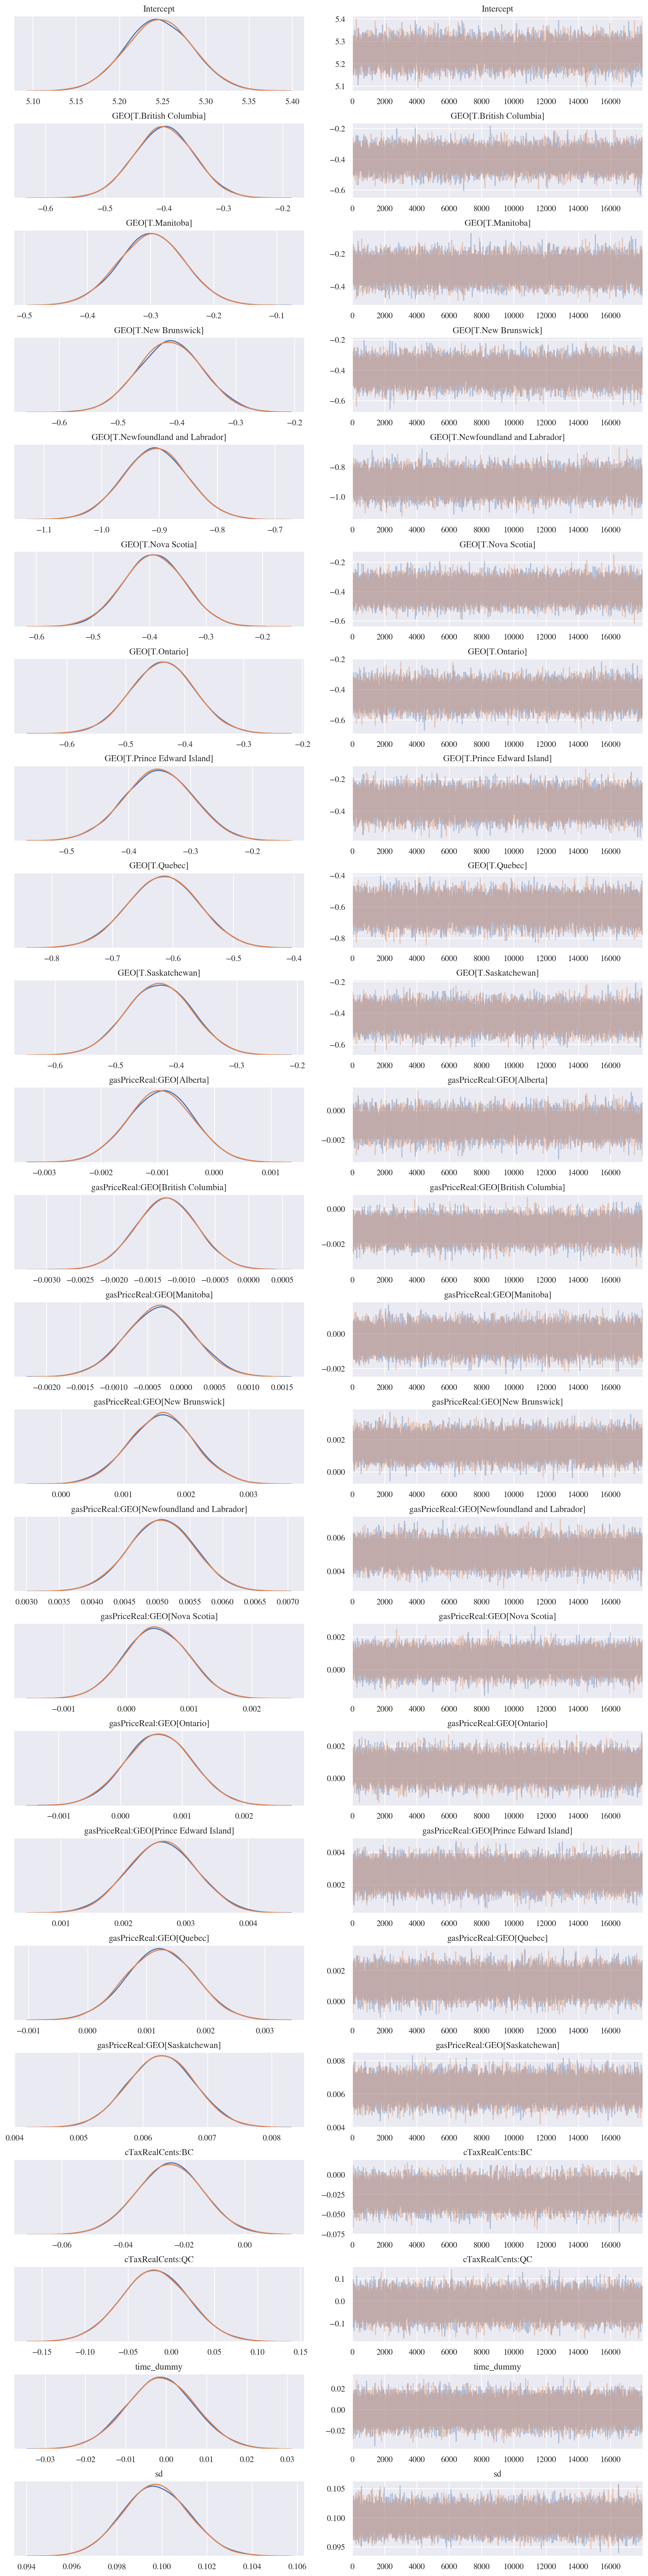

In [173]:
plt.figure(dpi=150)
pm.traceplot(trace[2000:]);

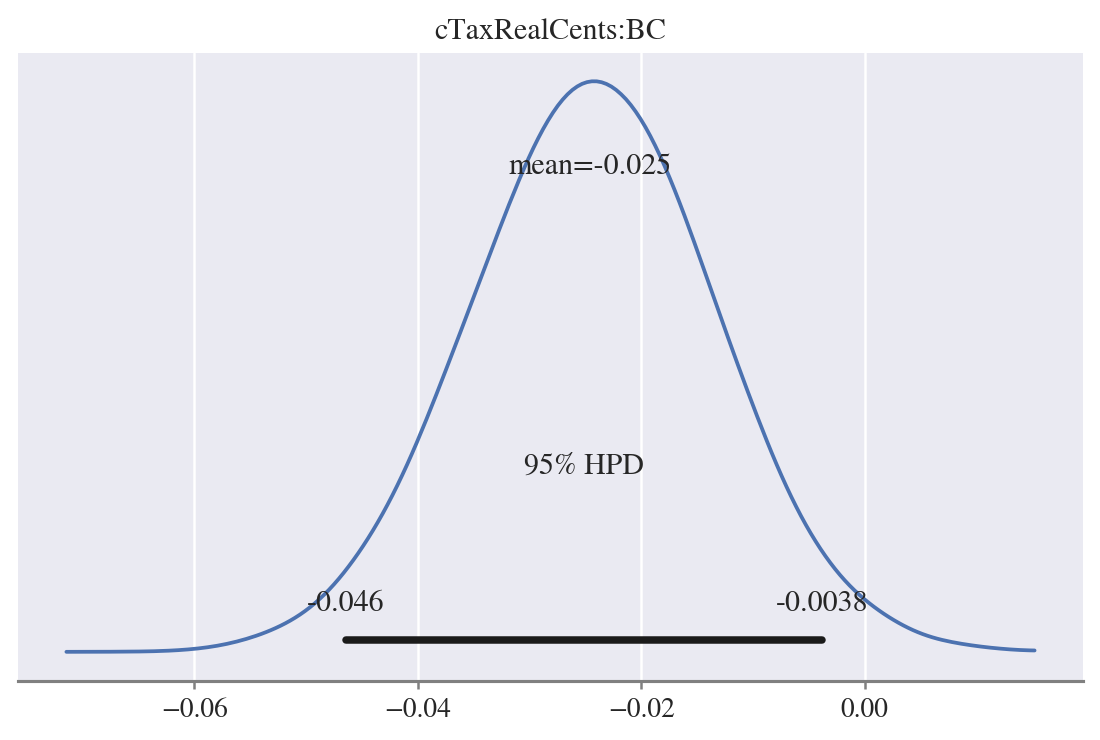

In [174]:
pm.plot_posterior(trace[2000:], point_estimate='mean', 
                  var_names = ['cTaxRealCents:BC'],
                  credible_interval = .95);

Here we have it, though we can't exclude the hypothesis of no effect, I think that we have a rather compelling point in digging more towards understanding the effects of carbon taxing on gas consumption. Additional work should be directed dealing with the heteroskedasticity and the parallel trend assumption.

Thank you for reading up to this point.

### END